In [1]:
%matplotlib notebook

In [2]:
import exMermin as DF

In [3]:

import sys
import pylab
import numpy
import sys
from periodictable import elements
from scipy.integrate import simps as integrate
from scipy.special import hyp2f1
from scipy.optimize import newton as root
import math



from LFC import Plasma, LFC, Farid
from Units import *

In [4]:
def calculate_response(k, omega, epsilon=1e-2, verbose=False, debug=False):
    if DF_init is None:
        raise RuntimeError("Dielectric formalism is not initialized, aborting now.")
        
    # Calculate real and imaginary part of dielectric function and the response function -Im (1/eps).   
    Im_eps_rpa_k = numpy.array([DF.ImepseRPA(k.m_as(1/bohr), w.m_as(rydberg)) for w in omega*hbar ])
    Re_eps_rpa_k = numpy.array([DF.ReepseRPA(k.m_as(1/bohr), w.m_as(rydberg)) for w in omega*hbar ])
    response_rpa_k = Im_eps_rpa_k/(Re_eps_rpa_k**2 + Im_eps_rpa_k**2)
    
    if debug:
        pylab.figure()
        pylab.semilogx(w_range/plasma.plasma_frequency, Re_eps_rpa_k, ".")
        pylab.semilogx(w_range/plasma.plasma_frequency, Im_eps_rpa_k, ".")
    
    # Handle weakly damped plasmon resonance.
    # Is there a plasmon mode (Re eps = 0)
    # Is Re eps negative somewhere?
    has_negatives = Re_eps_rpa_k < 0.0

    if any(has_negatives):
        
        # Get indices of all negative Re eps
        where_negatives = numpy.where(has_negatives)
        
        # Get index of last negative Re eps.
        lo_idx = where_negatives[0][-1]
        
        # Re eps = 0 is located between lo_idx and next frequency.
        resonance_band = omega[lo_idx:lo_idx+2]*second
        if verbose:
            print("Found resonance band: ", (resonance_band/second/plasma.plasma_frequency).m, "w_pl")
        
        # Make linear interpolation on logarithmized frequencies
        xlo = omega[lo_idx]
        xhi = omega[lo_idx+1]
        ylo = Re_eps_rpa_k[lo_idx]
        yhi = Re_eps_rpa_k[lo_idx+1]
        
        resonance = xlo - ylo*(xhi-xlo)/(yhi-ylo)
            

        m2 = integrate(x=omega.m_as(1/second), y=response_rpa_k * omega.m_as(1/second))
        fsum = math.pi*(plasma.plasma_frequency.m_as(1/second))**2 / 2.
        delta = fsum - m2
        relative_deviation = abs(m2/fsum-1.)
        if verbose: print("m2     = ",m2, "\nfsum   = ", fsum, "\ndelta  = ", delta, "\n% dev. = ", relative_deviation)
        
        if abs(relative_deviation) > epsilon:
            

            Abox = 2.*delta/(resonance_band[-1]**2 - resonance_band[0]**2)

            response_rpa_k[lo_idx] += Abox
                
                
    return omega, response_rpa_k       

In [5]:
DF_init = None

In [6]:
plasma = Plasma(elements=[elements.Al],
                electron_temperature=0.3*electronvolt/kB,
                electron_density=2.0e29*meter**-3,
                average_ionization=2.553,
               )
DF_init = DF.InitParameters(plasma.electron_density.m_as(meter**-3),
                            (plasma.electron_temperature*kB).m_as(electronvolt),
                            (plasma.electron_temperature*kB).m_as(electronvolt),
                            plasma.average_ionization)

In [7]:
fsum = 0.5*math.pi*(plasma.plasma_frequency)**2

In [8]:
k_range = DF.get_kappaeRy()/bohr * 10**numpy.linspace(-2,1.3,256)
print(k_range[0], k_range[-1])

0.011038088134485773 / bohr 22.023881284044606 / bohr


In [9]:
(hbar*plasma.plasma_frequency*100).to(electronvolt), (hbar**2*k_range[-1]**2/2/m_e*10.).to(electronvolt)

(<Quantity(1660.6273617459553, 'electronvolt')>,
 <Quantity(65994.58421433439, 'electronvolt')>)

In [10]:
w_max = max(plasma.plasma_frequency*100, hbar*k_range[-1]**2/2/m_e*20.)
print("Max. frequency (hbar*omega) = ",(hbar*w_max).to(electronvolt))
log10_wmax = math.log(w_max/plasma.plasma_frequency, 10)
w_range = plasma.plasma_frequency*10**numpy.linspace(-4, log10_wmax, 2048)
assert abs(hbar*w_range[-1] - hbar*w_max) < 1e-5*electronvolt

Max. frequency (hbar*omega) =  131989.1684286688 electronvolt


In [11]:
EF = (hbar**2*plasma.kF**2/2./m_e).to(joule)
theta = (kB*plasma.electron_temperature).to(joule)/EF
eta = DF.get_etae()
D = 1./theta
vF = (hbar*plasma.fermi_wavenumber/m_e).to(meter/second)
kappa = DF.get_kappaeRy()/bohr
hwpl = DF.get_wpleRy()*rydberg
rs = DF.get_RS()

In [12]:
print("*** Plasma parameters report ***")
print("EF    = {0:5.4e}".format(EF.to(electronvolt)))
print("theta = {0:5.4e}".format(theta.m))
print("eta   = {0:5.4e}".format(eta))
print("kappa = {0:5.4e}".format(kappa))
print("wpl   = {0:5.4e}".format(hwpl.to(electronvolt)))
print("rs    = {0:5.4e}".format(rs))

*** Plasma parameters report ***
EF    = 1.2471e+01 electronvolt
theta = 2.4056e-02
eta   = 4.1549e+01
kappa = 1.1038e+00 / bohr
wpl   = 1.6606e+01 electronvolt
rs    = 2.0046e+00


In [13]:
def lfc_integration_kernel(k,q,):
    return _lfc_integration_kernel_x(k/q, epsilon=1.0e-5)

In [14]:
def _lfc_integration_kernel_x(x, epsilon=1.0e-5):
    if abs(x-1.) < epsilon:
        return 5./6. - 0.5*x**2
    if abs(x) < epsilon:
        return 5./6.
    return 5./6. - 0.5*x**2 + 0.25*x**3*(1. - 1./x**2)**2 * numpy.log(abs(1.+x)/abs(1.-x))

###  Integration of RPA

In [15]:
def calculate_static_See(wavenumbers):
    sq = numpy.empty_like(wavenumbers)
    
    for iq, q in enumerate(wavenumbers):
        om, response = calculate_response(q, w_range, verbose=False)
        response = response/numpy.tanh(hbar*w_range/2./kB/plasma.electron_temperature)
        
        sq[iq] = (hbar*q**2 /math.pi/ m_e / plasma.plasma_frequency**2 * integrate(y=response,x=om)/second).m_as(one)
    
    return sq

In [16]:
#See_ks = calculate_static_See(wavenumbers=k_range)
#numpy.savetxt("See_k_Al_T0.3eV_n2e23cc_Z2.6.txt", See_ks)

In [17]:
See_ks = numpy.loadtxt("See_k_Al_T0.3eV_n2e23cc_Z2.6.txt")

<IPython.core.display.Javascript object>


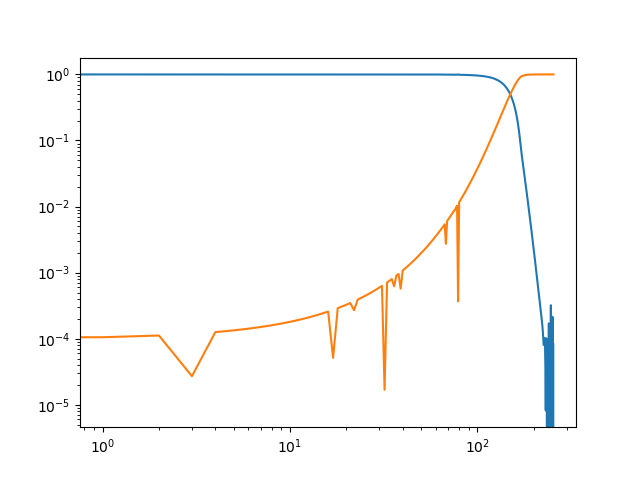

In [18]:
pylab.figure()
pylab.loglog((1.-See_ks))
pylab.loglog(See_ks)

In [19]:
def calculate_G_PV(wavenumber, Sk=None, epsilon=1e-2, ):
    """ Calculate static local field factor for given wavenumber (scalar). """
    
    
    if Sk is None:
        Sk = calculate_static_See(k_range)

    xs = (k_range/wavenumber).m_as(one)
        
    kern = numpy.array([_lfc_integration_kernel_x(x) for x in xs]) * k_range**2 * (1.-Sk)
    
    #mx = kern.max()
    #mx_idx = kern.argmax()
    #
    #for idx, ker in enumerate(kern[mx_idx:-1]):
    #    if kern[mx_idx+1] > ker or ker < mx*epsilon:
    #        break
    #    else:
    #        continue
    
    
    #pylab.figure()
    #pylab.loglog(Qs,kern)
    
    I = integrate(x=k_range, y=kern)

    return 0.25/numpy.pi**2/(plasma.electron_density*bohr**3)*I

In [20]:
Gpvs = numpy.array([calculate_G_PV(q, Sk=See_ks) for q in k_range[:-10:10]])

<IPython.core.display.Javascript object>


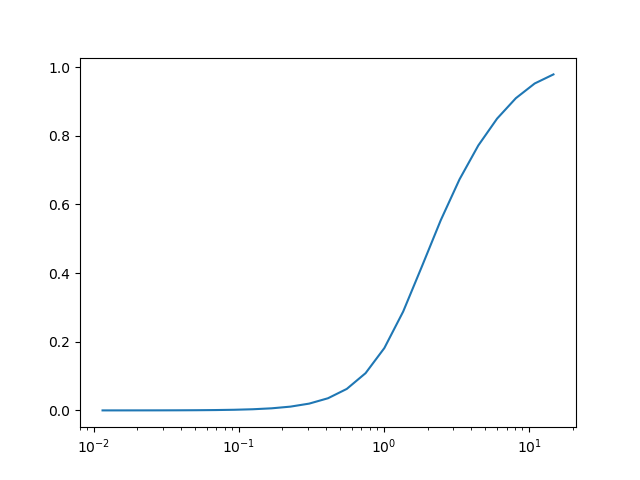

In [21]:
pylab.figure()
pylab.semilogx(k_range[:-10:10].to(1/meter)/plasma.kF,Gpvs)

## Dabrowski model for dynamic LFC

In [22]:
alpha = math.pow(4./9./math.pi, 1./3.)
C = 23./60.*alpha*plasma.rs
D = 0.763

### Use Farid for low freq. limit 

In [23]:
Gx = LFC(model=Farid, wavenumbers=k_range[:-10:10], energies=0.0*joule, plasma=plasma)

In [24]:
Gx.evaluate([1.2]/bohr)[0]

0.47873687726439

<IPython.core.display.Javascript object>


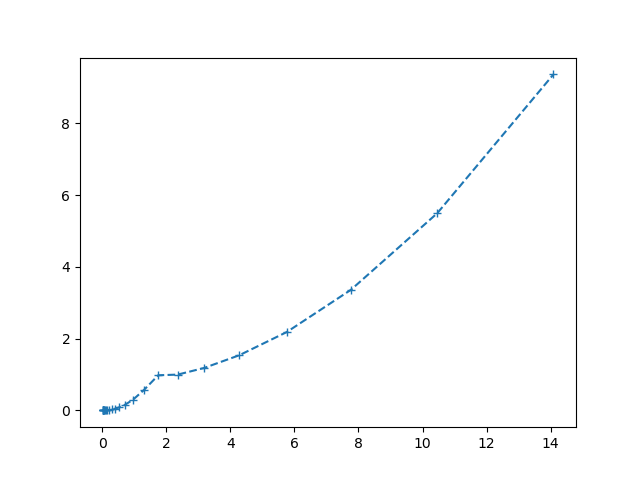

In [25]:
pylab.figure()
pylab.plot(k_range[:-10:10].m_as(1/bohr), Gx.evaluate(), "+--")

In [26]:
def pade_coeffs(wavenumber):
    
    qaB = wavenumber.m_as(1/bohr)
    gx = Gx.evaluate([qaB]/bohr)[0]
    gpv = calculate_G_PV(qaB/bohr, See_ks)
    quot = (gx-gpv)/(C*D*qaB**2)
    
    a = C*qaB**2*quot**(5./3.)
    b = quot**(4./3.)
    
    return a.m_as(one),b.m_as(one)

In [27]:
q = k_range[200]

In [28]:
pade_coeffs(q)

(0.26619843896358547, 0.0705284474805393)

## Pade ansatz for G(q,w) 

In [29]:
def calculate_dynamic_LFC(wavenumber, w_range):
    a,b = pade_coeffs(wavenumber)
    
    qaB = wavenumber.m_as(1/bohr)
    wRy = (hbar*w_range).m_as(rydberg)
    
    Im_G = a*wRy/(1.+b*wRy**2)**1.25
    
    Re_G_w_inf = calculate_G_PV(wavenumber, See_ks) 
    Re_G   = Re_G_w_inf - a*( wRy/(1.+b*wRy**2)**1.25 + 1.5225*hyp2f1(1, 3/2, 5/4, -1./(b*wRy**2)) )
    
    return Re_G + 1j*Im_G

In [30]:
q = 0.6/bohr
Gwq = calculate_dynamic_LFC(wavenumber=q, w_range=w_range)

<IPython.core.display.Javascript object>


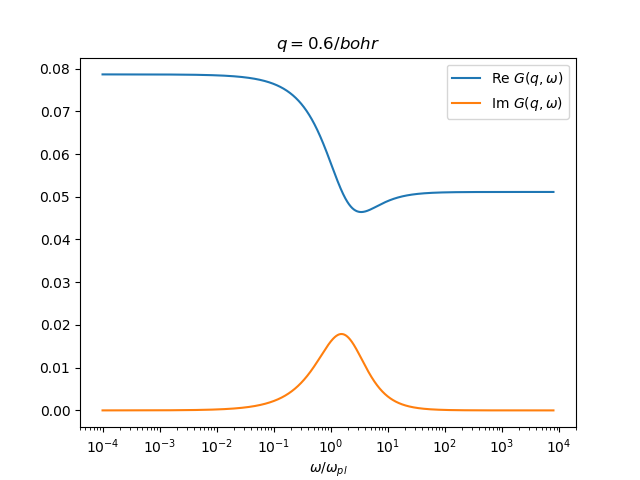

Text(0.5, 1.0, '$q = 0.6 / bohr$')

In [31]:
pylab.figure()
pylab.semilogx(w_range/plasma.plasma_frequency, numpy.real(Gwq), label=r"Re $G(q, \omega)$")
pylab.semilogx(w_range/plasma.plasma_frequency, numpy.imag(Gwq), label=r"Im $G(q, \omega)$")
pylab.xlabel(r"$\omega/\omega_{pl}$")
pylab.legend()
pylab.title(r"$q = {0:s}$".format(q.__str__()) )

In [32]:
G = calculate_dynamic_LFC(q, plasma.plasma_frequency).m

In [33]:
G.real , G.imag

(0.057834907520130624, 0.016154028823705778)

In [74]:
def calculate_See0(k, w, G):
    Re_G = G.real.m_as(one)
    Im_G = G.imag.m_as(one)
    
    hws = (hbar*w).m_as(rydberg)
    
    See_kw_s = numpy.empty_like(w)
    for i, hw in enumerate(hws):
        #print(i, hw, Re_G[i], Im_G[i])
        See_kw_s[i] = DF.See0(k.m_as(1/bohr), hw, Re_G[i], Im_G[i])
    
    return See_kw_s

In [75]:
q = 0.5*DF.get_kappaeRy()/bohr
hw = DF.get_wpleRy()

In [76]:
Gwq = calculate_dynamic_LFC(q, w_range)

In [77]:
Re_G = Gwq.real.m
Im_G = Gwq.imag.m

<IPython.core.display.Javascript object>


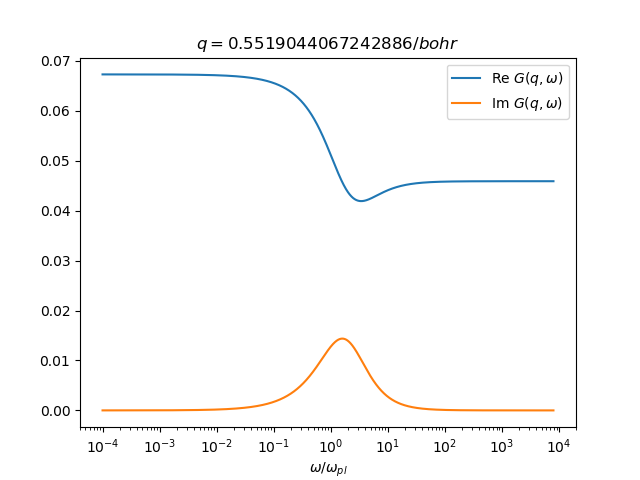

Text(0.5, 1.0, '$q = 0.5519044067242886 / bohr$')

In [78]:
pylab.figure()
pylab.semilogx(w_range/plasma.plasma_frequency, numpy.real(Gwq), label=r"Re $G(q, \omega)$")
pylab.semilogx(w_range/plasma.plasma_frequency, numpy.imag(Gwq), label=r"Im $G(q, \omega)$")
pylab.xlabel(r"$\omega/\omega_{pl}$")
pylab.legend()
pylab.title(r"$q = {0:s}$".format(q.__str__()) )

In [39]:
qaBs = numpy.array([0.33710299, 1.19522306])/bohr

In [79]:
ws = numpy.linspace(0.1,10,100)*plasma.plasma_frequency
q = qaBs[1]

In [80]:
Gwq = calculate_dynamic_LFC(wavenumber=q, w_range=ws)

<IPython.core.display.Javascript object>


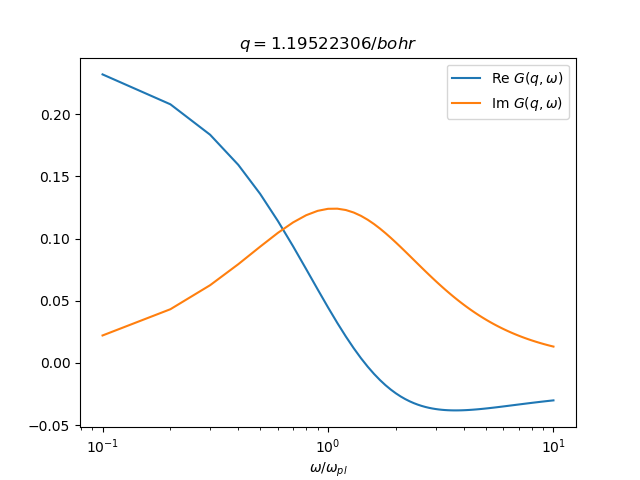

Text(0.5, 1.0, '$q = 1.19522306 / bohr$')

In [81]:
pylab.figure()
pylab.semilogx(ws/plasma.plasma_frequency, numpy.real(Gwq), label=r"Re $G(q, \omega)$")
pylab.semilogx(ws/plasma.plasma_frequency, numpy.imag(Gwq), label=r"Im $G(q, \omega)$")
pylab.xlabel(r"$\omega/\omega_{pl}$")
pylab.legend()
pylab.title(r"$q = {0:s}$".format(q.__str__()) )

In [43]:
#DF.InitSee(0.1*DF.get_wpleRy(), 10.*DF.get_wpleRy(), q.m_as(1/bohr), 0.25)

In [82]:
def dispersion_from_S(x,y,offset=0):
    return abs(x[numpy.argmax(y)] - offset)

In [83]:
qaBs

<Quantity([0.33710299 1.19522306], '1 / bohr')>

In [84]:
See_kw_s = calculate_See0(0.337/bohr, -ws, Gwq)

<IPython.core.display.Javascript object>


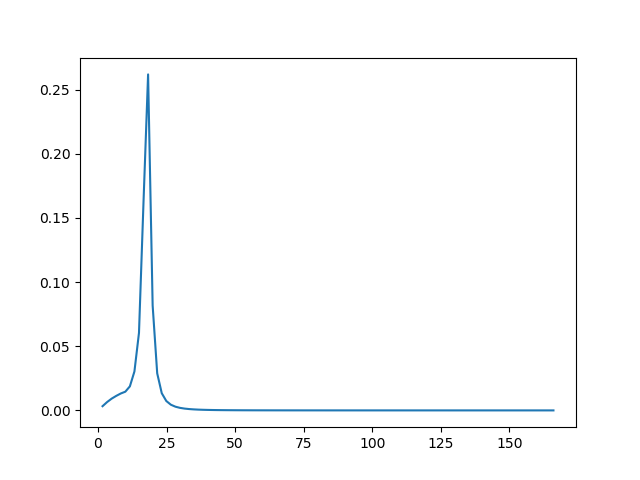

In [85]:
pylab.figure()
pylab.plot((hbar*ws).to(electronvolt), See_kw_s)

In [48]:
dispersion_from_S((hbar*ws).to(electronvolt), See_kw_s)

<Quantity(18.266900979205513, 'electronvolt')>

### Dispersion curve with dynamical LFC 

In [52]:
disp_dLFC = []
qs = numpy.arange(0.2,1.225,0.025)/bohr
ws = numpy.linspace(1.0,2.5,100)*plasma.plasma_frequency

In [53]:

for q in qs:
    Gwq = calculate_dynamic_LFC(wavenumber=q, w_range=ws)
    See_kw_s = calculate_See0(q, -ws, Gwq)
    
    plasmon_dispersion = dispersion_from_S((hbar*ws).to(electronvolt), See_kw_s)
    
    disp_dLFC.append(plasmon_dispersion.m)

disp_dLFC = disp_dLFC*electronvolt

<IPython.core.display.Javascript object>


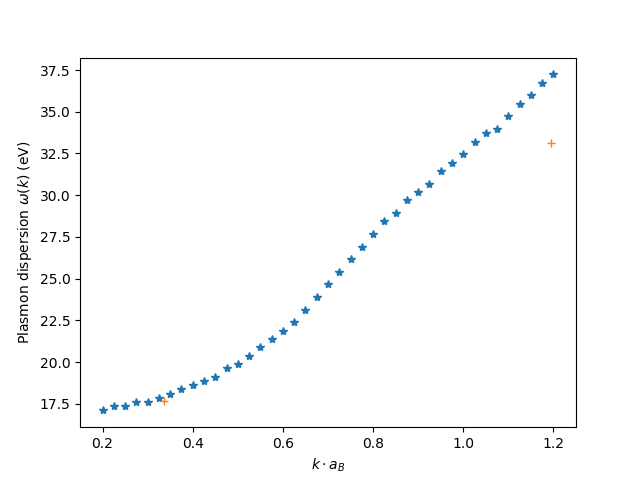

Text(0, 0.5, 'Plasmon dispersion $\\omega(k)$ (eV)')

In [63]:
pylab.figure()
pylab.plot(qs, disp_dLFC, "*")
pylab.plot(kaB_from_angle(7.2e3,experiment_disp[:,0]), experiment_disp[:,1],"+")
pylab.xlabel(r"$k\cdot a_{B}$")
pylab.ylabel(r"Plasmon dispersion $\omega(k)$ (eV)")

In [55]:
disp_dLFC

<Quantity([17.10949403 17.36110424 17.36110424 17.61271444 17.61271444 17.86432465
 18.11593486 18.36754506 18.61915527 18.87076547 19.12237568 19.62559609
 19.8772063  20.38042671 20.88364712 21.38686754 21.89008795 22.39330836
 23.14813898 23.9029696  24.65780022 25.41263084 26.16746146 26.92229208
 27.6771227  28.43195331 28.93517373 29.69000435 30.19322476 30.69644517
 31.45127579 31.9544962  32.45771662 33.21254723 33.71576765 33.96737785
 34.72220847 35.47703909 35.9802595  36.73509012 37.23831054], 'electronvolt')>

In [56]:
def kaB_from_angle(photon_energy, angle):
    """ convert scattering angle in deg. to wavenumber in 1/aB."""
    return 4.*numpy.pi*photon_energy/1239.8 * numpy.sin(angle*numpy.pi/180./2.) * 0.053

In [57]:
def kA_from_angle(photon_energy, angle):
    """ convert scattering angle in deg. to wavenumber in 1/aB."""
    return 4.*numpy.pi*photon_energy/1239.8 * numpy.sin(angle*numpy.pi/180./2.) * 0.1

In [58]:
kaB_from_angle(7200, numpy.array([10,36]))

array([0.33710299, 1.19522306])

## Experimental data 

In [59]:
experiment_disp =numpy.array([[10.,17.7],[36.,33.1]])

In [60]:
photon_energy = 7.2e3

In [12]:
angles = numpy.arange(5.0,45.0,1.0)
#angles = numpy.array([10.0, 36.0])
wavenumbers_aB = numpy.array(kaB_from_angle(photon_energy, angles))
wavenumbers_A = wavenumbers_aB / 0.53


### Dispersion curve with PV LFC 

In [86]:
disp_PV = []
qs = numpy.arange(0.2,1.225,0.025)/bohr
ws = numpy.linspace(1.0,2.5,100)*plasma.plasma_frequency


In [87]:
q = DF.get_kappaeRy()/bohr
Gwq = calculate_G_PV(q, Sk=See_ks, epsilon=1e-2, )

In [88]:
Gwq.m

3.346190995099127e-32

In [90]:

for q in qs:
    Gwq = numpy.ones_like(ws)*(calculate_G_PV(q, Sk=See_ks) + 1j*0.0)
    
    See_kw_s = calculate_See0(q, -ws, Gwq)
    
    plasmon_dispersion = dispersion_from_S((hbar*ws).to(electronvolt), See_kw_s)
    
    disp_PV.append(plasmon_dispersion.m)

disp_PV = disp_PV*electronvolt

<IPython.core.display.Javascript object>


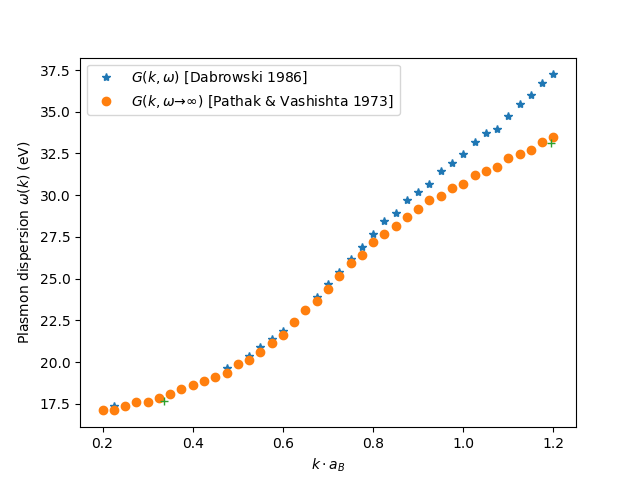

In [95]:
pylab.figure()
pylab.plot(qs, disp_dLFC, "*", label=r"$G(k,\omega)$ [Dabrowski 1986]")
pylab.plot(qs, disp_PV, "o", label=r"$G(k,\omega\to\infty)$ [Pathak & Vashishta 1973]")
pylab.plot(kaB_from_angle(7.2e3,experiment_disp[:,0]), experiment_disp[:,1],"+")
pylab.xlabel(r"$k\cdot a_{B}$")
pylab.ylabel(r"Plasmon dispersion $\omega(k)$ (eV)")
pylab.legend(loc=2)
pylab.savefig("/home/grotec/mnt/max-gpfs/Al_PlasmonDispersion/dispersion_exp_dlfc_pv.png")

## All models plus experimental data. 

In [98]:
rpa_disp = numpy.loadtxt("/home/grotec/Projects/Al_PlasmonDispersion/Al_dispersion_RPA_T0.3_Z2.6_comp1.3_angle_vs_peakposition.txt")

In [100]:
rpa_disp_eps = numpy.loadtxt("/home/grotec/Projects/Al_PlasmonDispersion/Al_dispersion_from_epsilon_RPA_T0.3_Z2.6_comp1.3_angle_vs_peakposition.txt")

In [102]:
farid_disp = numpy.loadtxt("/home/grotec/Projects/Al_PlasmonDispersion/Al_dispersion_SLFC_T0.3_Z2.6_comp1.3_angle_vs_peakposition.txt")

In [103]:
farid_disp_eps = numpy.loadtxt("/home/grotec/Projects/Al_PlasmonDispersion/Al_dispersion_from_epsilon_SLFC_T0.3_Z2.6_comp1.3_angle_vs_peakposition.txt")

In [107]:
xbmaUI_disp = numpy.loadtxt("/home/grotec/Projects/Al_PlasmonDispersion/Al_dispersion_BMA+sLFCIchimaru_T0.3_Z2.6_comp1.3_angle_vs_peakposition.txt")

In [110]:
bma_disp = numpy.loadtxt("/home/grotec/Projects/Al_PlasmonDispersion/Al_dispersion_BMA_T0.3_Z2.6_comp1.3_angle_vs_peakposition.txt")

In [115]:
angles = rpa_disp[:,0]

<IPython.core.display.Javascript object>


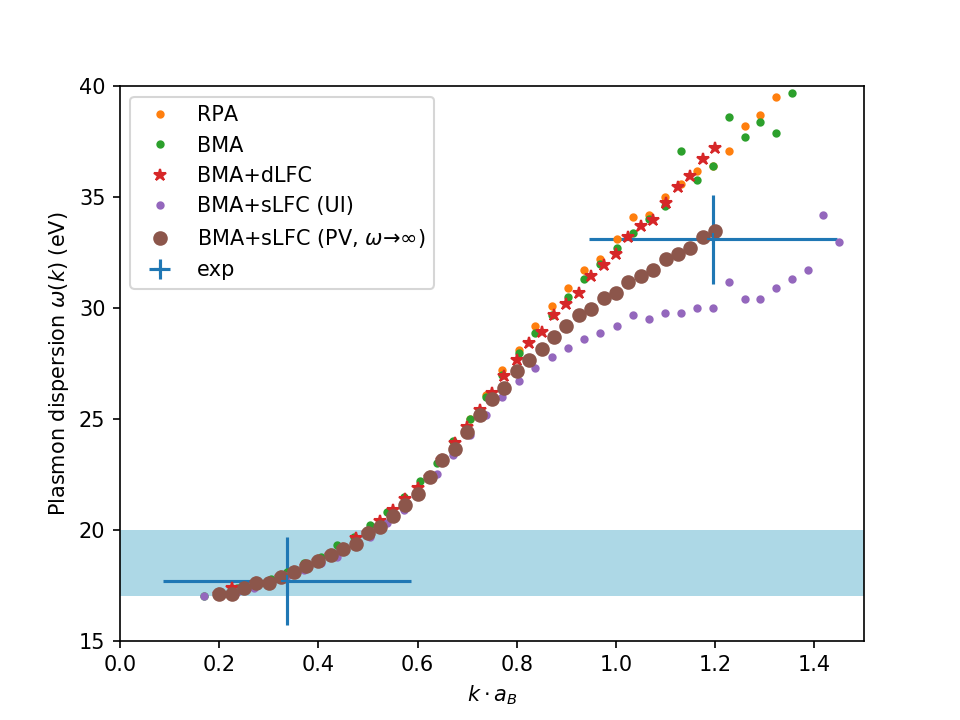

In [189]:
pylab.figure()
pylab.fill_between(numpy.arange(0,1.6,0.01),17.0,20.0, facecolor='lightblue', interpolate=True)
pylab.errorbar(kaB_from_angle(7.2e3,experiment_disp[:,0]), experiment_disp[:,1], yerr=2.0, xerr=0.25, fmt="+", label="exp")
pylab.plot(kaB_from_angle(7.2e3,angles[angles>20]), rpa_disp[:,1][angles>20], ".",label="RPA")
#pylab.plot(kaB_from_angle(7.2e3,rpa_disp_eps[:,0]), rpa_disp_eps[:,1], "orange" ,label=r"RPA (Re $\epsilon=0$)")
pylab.plot(kaB_from_angle(7.2e3,angles), bma_disp[:,1], ".",label="BMA")
#pylab.plot(kaB_from_angle(7.2e3,angles), farid_disp[:,1], ".",label="sLFC (UI)")
#pylab.plot(kaB_from_angle(7.2e3,farid_disp_eps[:-25,0]), farid_disp_eps[:-25,1], "green",label=r"sLFC (Re $\epsilon=0$)")
pylab.plot(qs, disp_dLFC, "*", label=r"BMA+dLFC")
pylab.plot(kaB_from_angle(7.2e3,xbmaUI_disp[:,0]), xbmaUI_disp[:,1], ".",label=r"BMA+sLFC (UI)")
pylab.plot(qs, disp_PV, "o", label=r"BMA+sLFC (PV, $\omega\to\infty$)")
pylab.xlim([0.0,1.5])
pylab.ylim([15,40])
pylab.xlabel(r"$k\cdot a_{B}$")
pylab.ylabel(r"Plasmon dispersion $\omega(k)$ (eV)")
pylab.legend(loc=2)
#pylab.savefig("/home/grotec/mnt/max-gpfs/Al_PlasmonDispersion/dispersion_exp_dlfc_pv.png")

# Appendix

<IPython.core.display.Javascript object>


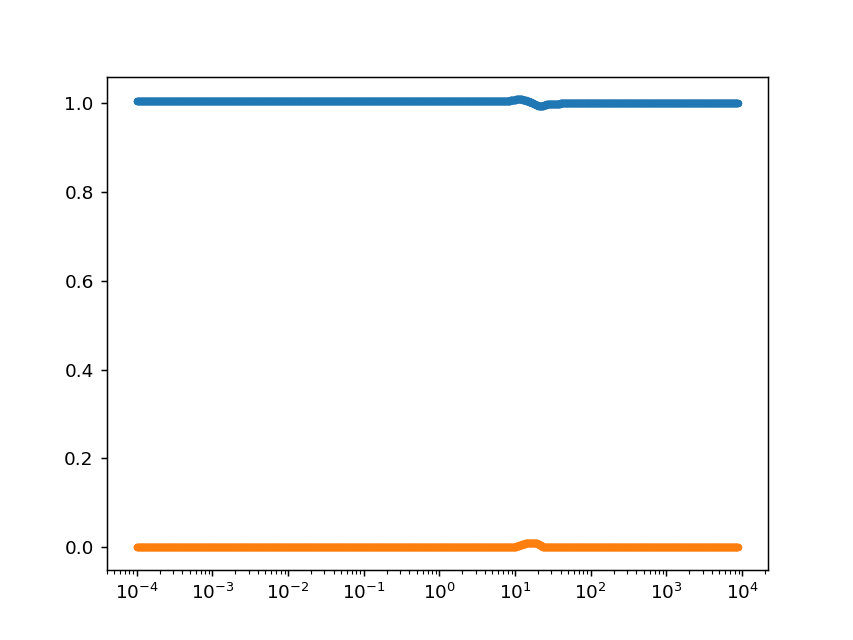

<IPython.core.display.Javascript object>


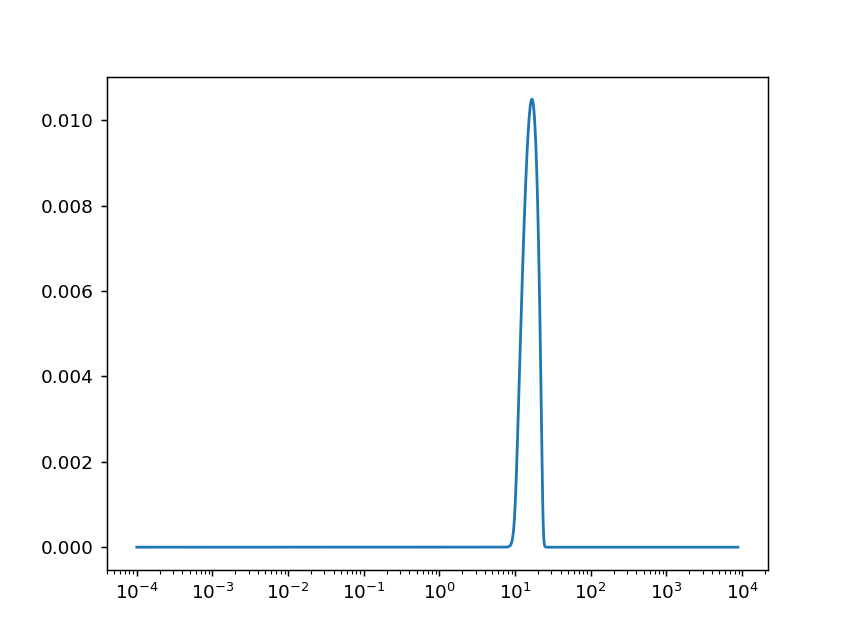

In [36]:
k = 20./bohr
w, response = calculate_response(q, omega=w_range, verbose=True, debug=True)

pylab.figure()
pylab.semilogx(w/plasma.plasma_frequency, response)

<IPython.core.display.Javascript object>


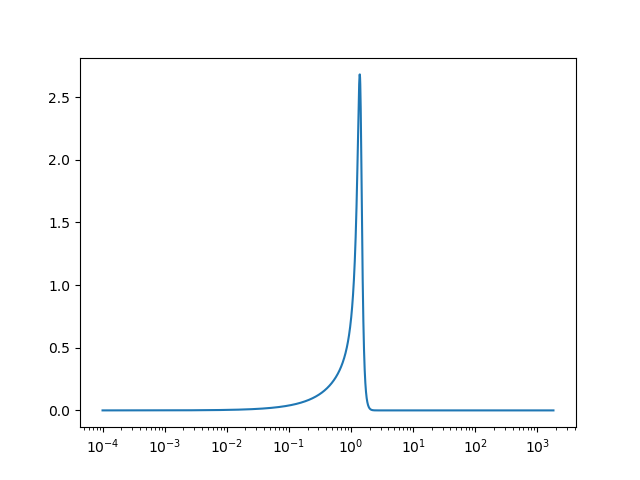

In [360]:
k = plasma.debye_kappa*0.5
w, response = calculate_response(k=k, omega=w_range, verbose=False)

pylab.figure()
pylab.semilogx(w/plasma.plasma_frequency, response)

<IPython.core.display.Javascript object>


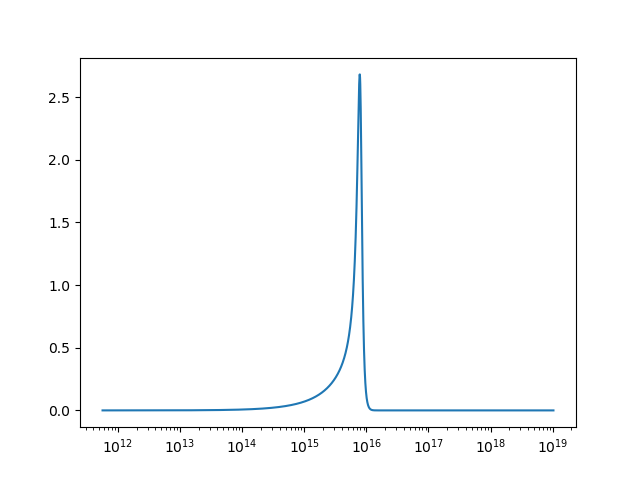

In [308]:
x,y = calculate_response(k, w_range)
pylab.figure()
pylab.semilogx(x,y)

In [ ]:
for k in k_range:
    

In [264]:
fsum = 0.5*math.pi*(plasma.plasma_frequency.m_as(1/second))**2; fsum

4.999227933850756e+31

In [244]:
def calculate_response_large_k(k, omega, verbose=False, debug=False):
    """ Table II in Arista,Brandt 1984 col. 2, row 4."""
    
    u = (omega/k/vF).to(one)
    z = 0.5*(k/plasma.fermi_wavenumber).to(one)
    
    return 0.125/plasma.kF/bohr/z**3 * theta * numpy.log(1. + numpy.exp(eta - D*(u-z)**2))

In [292]:
def calculate_response_large_k_classical(k, omega, verbose=False, debug=False):
    """ Table II in Arista,Brandt 1984 col. 4, row 4."""
    
    u = (omega/k/vF).to(one)
    z = 0.5*(k/plasma.fermi_wavenumber).to(one)
    if verbose:
        print("u = [", u[0], "..", u[-1])
        print("z = ", z)
    
    x = 2.*z
    g = DF.ge(x.m)
    
    Re_eps = 1. + 2./(plasma.kF*bohr).to(one)/numpy.pi*pow(plasma.kF/k, 3) * g
    Im_eps = 0.125/plasma.kF/bohr/z**3 * theta * numpy.exp(eta - D*(u-z)**2)
    
    return Im_eps/(Re_eps**2 + Im_eps**2)

In [296]:
k = 5.*plasma.debye_kappa
response_large_k = calculate_response_large_k(k, w_range[1000:])
response_large_k_cl = calculate_response_large_k_classical(k, w_range[1000:], verbose=True)
w,response_k = calculate_response(k, w_range[1000:])

u = [ 0.01953352098915351 dimensionless .. 111.50069645125286 dimensionless
z =  7.405944513552496 dimensionless


<IPython.core.display.Javascript object>


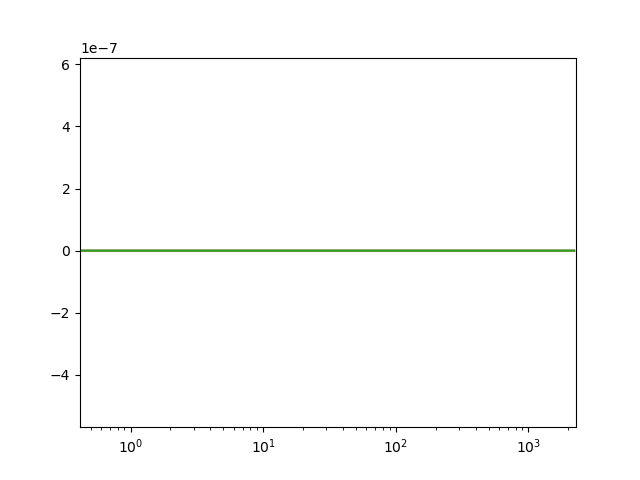

In [294]:
pylab.figure()
pylab.plot(w/plasma.plasma_frequency, response_large_k)
pylab.plot(w/plasma.plasma_frequency, response_large_k_cl)
pylab.plot(w/plasma.plasma_frequency, response_k)


<IPython.core.display.Javascript object>


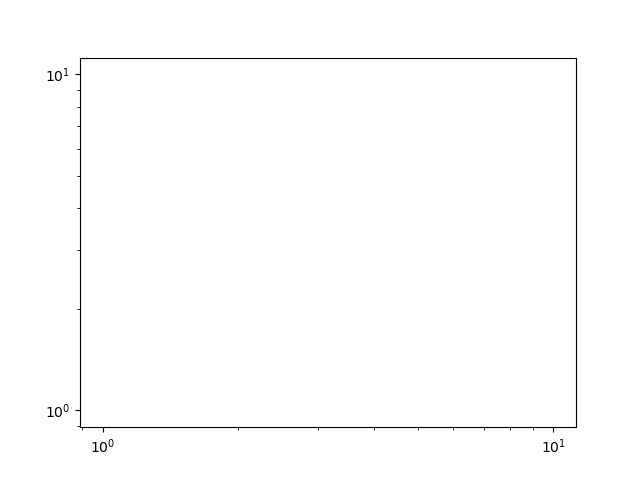

ValueError: x and y must have same first dimension, but have shapes (2048,) and (1048,)

In [295]:
pylab.figure()
pylab.loglog(w_range/plasma.plasma_frequency, response_large_k)
pylab.loglog(w_range/plasma.plasma_frequency, response_large_k_cl)
pylab.loglog(w_range/plasma.plasma_frequency, response_k)


In [17]:
# kern = numpy.array([[_lfc_integration_kernel_x(x) for x in k_range/q] for q in k_range[:-10]])

In [19]:
# kern.shape

(246, 256)

<IPython.core.display.Javascript object>


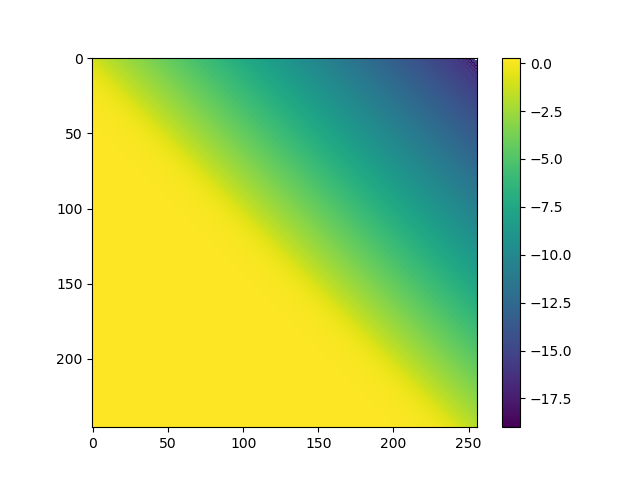

/home/grotec/Codes/anaconda3/envs/simex/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


In [20]:
# pylab.figure()
# pylab.imshow(numpy.log(kern))
# pylab.colorbar()

<IPython.core.display.Javascript object>


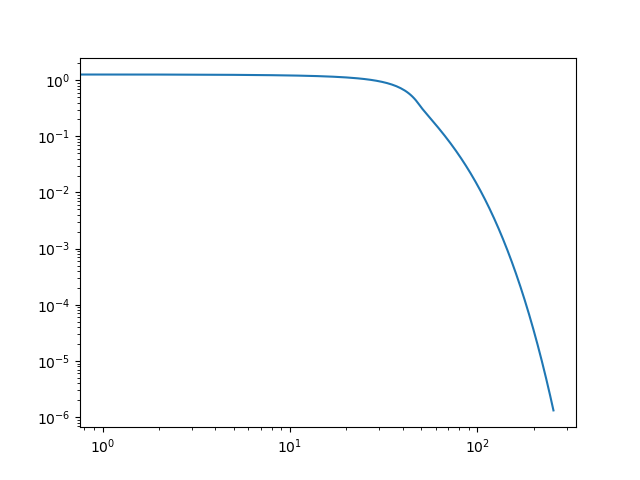

In [55]:
pylab.figure()
pylab.loglog(kern[50,:])

<IPython.core.display.Javascript object>


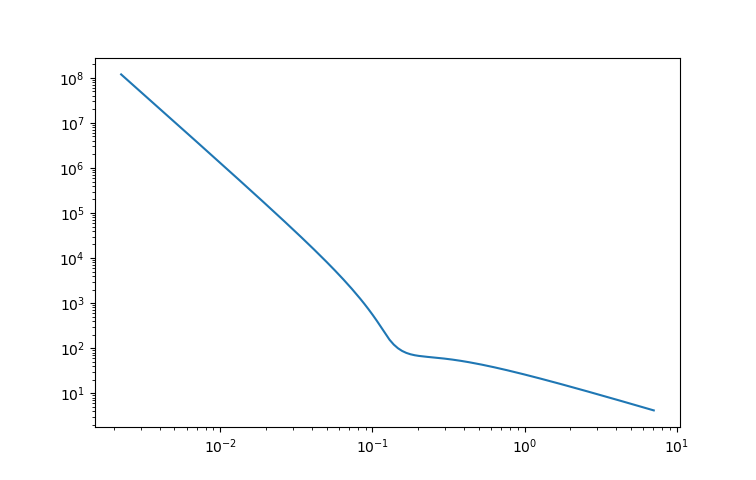

In [57]:
pylab.figure()
pylab.loglog(k_range*bohr, kern/k_range**3)

In [48]:
def dispersion_relation(hwRy, qaB):
    G = calculate_dynamic_LFC(qaB/bohr, hwRy*rydberg/hbar).m    
    return DF.dispersionGM(qaB, hwRy, G.real, G.imag)

In [49]:
DF.get_kappaeRy()

1.1038088134485773

In [50]:
DF.get_kFRy()

0.9573809818684279

In [41]:
dispersion_relation(DF.get_wpleRy(), 2.0*DF.get_kappaeRy())

AttributeError: module 'exMermin' has no attribute 'dispersionGM'

In [ ]:
def calculate_dispersion(q):
    wplRy = DF.get_wpleRy()
    kaB = q.m_as(1/bohr)
    return root(dispersion_relation, wplRy, args=(kaB,))

In [ ]:
calculate_dispersion(DF.get_kappaeRy()/bohr)/DF.get_wpleRy()

In [ ]:
dispersionLFC = [calculate_dispersion(x/bohr) for x in numpy.linspace(0.1, 1.1, 39)]*rydberg

In [ ]:
pylab.figure()
qs = numpy.linspace(0.1, 1.1, 39)/bohr

pylab.plot(qs, dispersionLFC.to(electronvolt))